In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score as auc
from sklearn.metrics import mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelBinarizer,LabelEncoder
from sklearn.model_selection import cross_val_score
from scipy import stats
import seaborn as sns
import copy as deepcopy
%matplotlib inline
%config InlineBackend.figure_format='retina'


In [7]:
list_train = []
count =0
with open('train.csv') as f:
    for li in f.readlines():
        li=li.replace('\n', '')
        lis = li.split(',')
        if len(lis)>132:
            li = li.replace(', .',',0.').replace(' ','')
            lis = li.split(',')
            list_train.append(lis[:-1])
        else:
            list_train.append(lis)
train = pd.DataFrame(list_train[1:],columns=list_train[0])            
num_columns = [i for i in train.columns.tolist() if 'cont' in i]
for i in num_columns:
    train[i]=train[i].astype('float64')
train['loss']=train['loss'].astype('float64')  
train['log_loss'] = np.log(train['loss'])

In [8]:
list_test = []
count =0
with open('test.csv') as f:
    for li in f.readlines():
        li=li.replace('\n', '')
        lis = li.split(',')
        if len(lis)>131:
            li = li.replace(', .',',0.').replace(' ','')
            lis = li.split(',')
            list_test.append(lis[:-1])
        else:
            list_test.append(lis)
test = pd.DataFrame(list_test[1:],columns=list_test[0])            
num_columns = [i for i in test.columns.tolist() if 'cont' in i]
for i in num_columns:
    test[i]=test[i].astype('float64')


In [9]:
test.head()

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
0,4,A,B,A,A,A,A,A,A,B,...,0.281143,0.466591,0.317681,0.61229,0.34365,0.38016,0.377724,0.369858,0.704052,0.392562
1,6,A,B,A,B,A,A,A,A,B,...,0.836443,0.482425,0.443760,0.71330,0.51890,0.60401,0.689039,0.675759,0.453468,0.208045
2,9,A,B,A,B,B,A,B,A,B,...,0.718531,0.212308,0.325779,0.29758,0.34365,0.30529,0.245410,0.241676,0.258586,0.297232
3,12,A,A,A,A,B,A,A,A,A,...,0.397069,0.369930,0.342355,0.40028,0.33237,0.31480,0.348867,0.341872,0.592264,0.555955
4,15,B,A,A,A,A,B,A,A,A,...,0.302678,0.398862,0.391833,0.23688,0.43731,0.50556,0.359572,0.352251,0.301535,0.825823


In [11]:
print('Frist 20 columns',list(train.columns[:20]))
print('Last 20 columns',list(train.columns[-20:]))

Frist 20 columns ['id', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'cat10', 'cat11', 'cat12', 'cat13', 'cat14', 'cat15', 'cat16', 'cat17', 'cat18', 'cat19']
Last 20 columns ['cat113', 'cat114', 'cat115', 'cat116', 'cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6', 'cont7', 'cont8', 'cont9', 'cont10', 'cont11', 'cont12', 'cont13', 'cont14', 'loss', 'log_loss']


In [14]:
train.shape

(200868, 133)

In [15]:
train.dropna(inplace=True)
train.shape

(194592, 133)

In [16]:
cat_features = list(train.select_dtypes(include=['object']).columns)
cont_features = [cont for cont in list(train.select_dtypes(include=['float64','int64']).columns) if cont not in ['loss','id']]
id_col = list(train.select_dtypes(include=['int64']).columns)
print(len(cat_features))

117


In [21]:
train = train.drop_duplicates('id')


In [33]:
cat_uniques = []
for cat in cat_features:
    cat_uniques.append(len(train[cat].unique()))


In [36]:
uniq_values_in_categories = pd.DataFrame()
uniq_values_in_categories['cat_name']=cat_features[1:]
uniq_values_in_categories['cat_uniuqe']=cat_uniques[1:]
uniq_values_in_categories.head()

,cat_name,cat_uniuqe
0,cat1,2
1,cat2,2
2,cat3,2
3,cat4,2
4,cat5,2


Text(7, 71, 'Binary features')

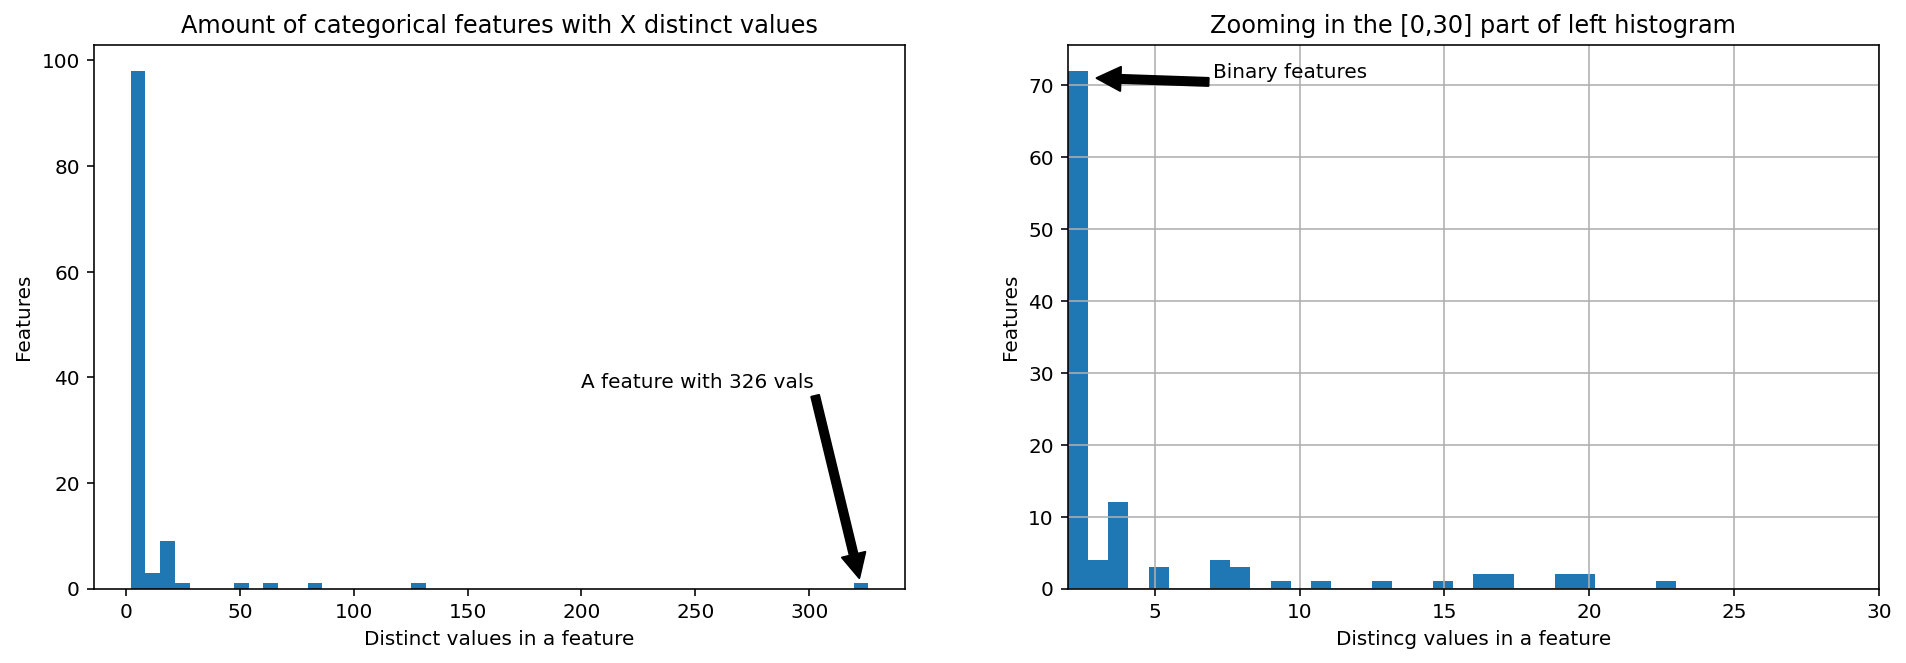

In [39]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(16,5)
ax1.hist(uniq_values_in_categories.cat_uniuqe, bins=50)
ax1.set_title('Amount of categorical features with X distinct values')
ax1.set_xlabel('Distinct values in a feature')
ax1.set_ylabel('Features')
ax1.annotate('A feature with 326 vals', xy=(322, 2), xytext=(200, 38), arrowprops=dict(facecolor='black'))

ax2.set_xlim(2,30)
ax2.set_title('Zooming in the [0,30] part of left histogram')
ax2.set_xlabel('Distincg values in a feature')
ax2.set_ylabel('Features')
ax2.grid(True)
ax2.hist(uniq_values_in_categories[uniq_values_in_categories.cat_uniuqe<=30].cat_uniuqe,bins=30)
ax2.annotate('Binary features',xy=(3,71),xytext=(7,71),arrowprops=dict(facecolor='black'))


In [ ]:
plt.figure(figsize=(16,8))
plt.plot(train['id'],train['loss'])
plt.title('Loss values per id')
plt.xlabel('id')
plt.ylabel('loss')
plt.legend()
plt.show()

In [43]:
stats.mstats.skew(train['loss']).data

array(3.79492815)

In [45]:
stats.mstats.skew(train['loss']).data

array(3.79492815)

In [46]:
stats.mstats.skew(np.log(train['loss'])).data

array(0.0929738)

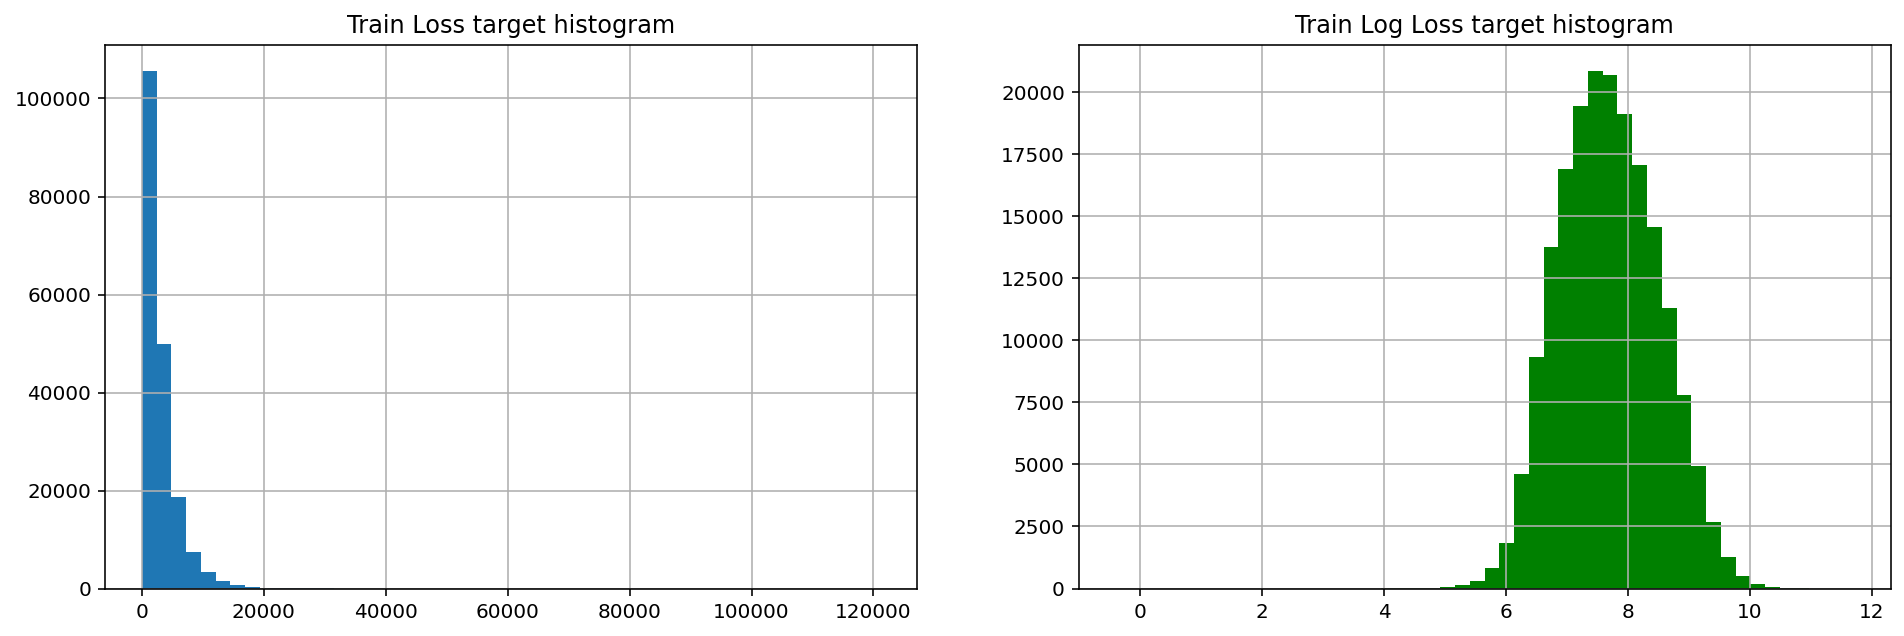

In [47]:
fig,(ax1,ax2) = plt.subplots(1,2)
fig.set_size_inches(16,5)
ax1.hist(train['loss'],bins=50)
ax1.set_title('Train Loss target histogram')
ax1.grid(True)
ax2.hist(np.log(train['loss']),bins=50,color='g')
ax2.set_title('Train Log Loss target histogram')
ax2.grid(True)
plt.show()

array([[<AxesSubplot:title={'center':'cont1'}>,
        <AxesSubplot:title={'center':'cont2'}>,
        <AxesSubplot:title={'center':'cont3'}>,
        <AxesSubplot:title={'center':'cont4'}>],
       [<AxesSubplot:title={'center':'cont5'}>,
        <AxesSubplot:title={'center':'cont6'}>,
        <AxesSubplot:title={'center':'cont7'}>,
        <AxesSubplot:title={'center':'cont8'}>],
       [<AxesSubplot:title={'center':'cont9'}>,
        <AxesSubplot:title={'center':'cont10'}>,
        <AxesSubplot:title={'center':'cont11'}>,
        <AxesSubplot:title={'center':'cont12'}>],
       [<AxesSubplot:title={'center':'cont13'}>,
        <AxesSubplot:title={'center':'cont14'}>,
        <AxesSubplot:title={'center':'log_loss'}>, <AxesSubplot:>]],
      dtype=object)

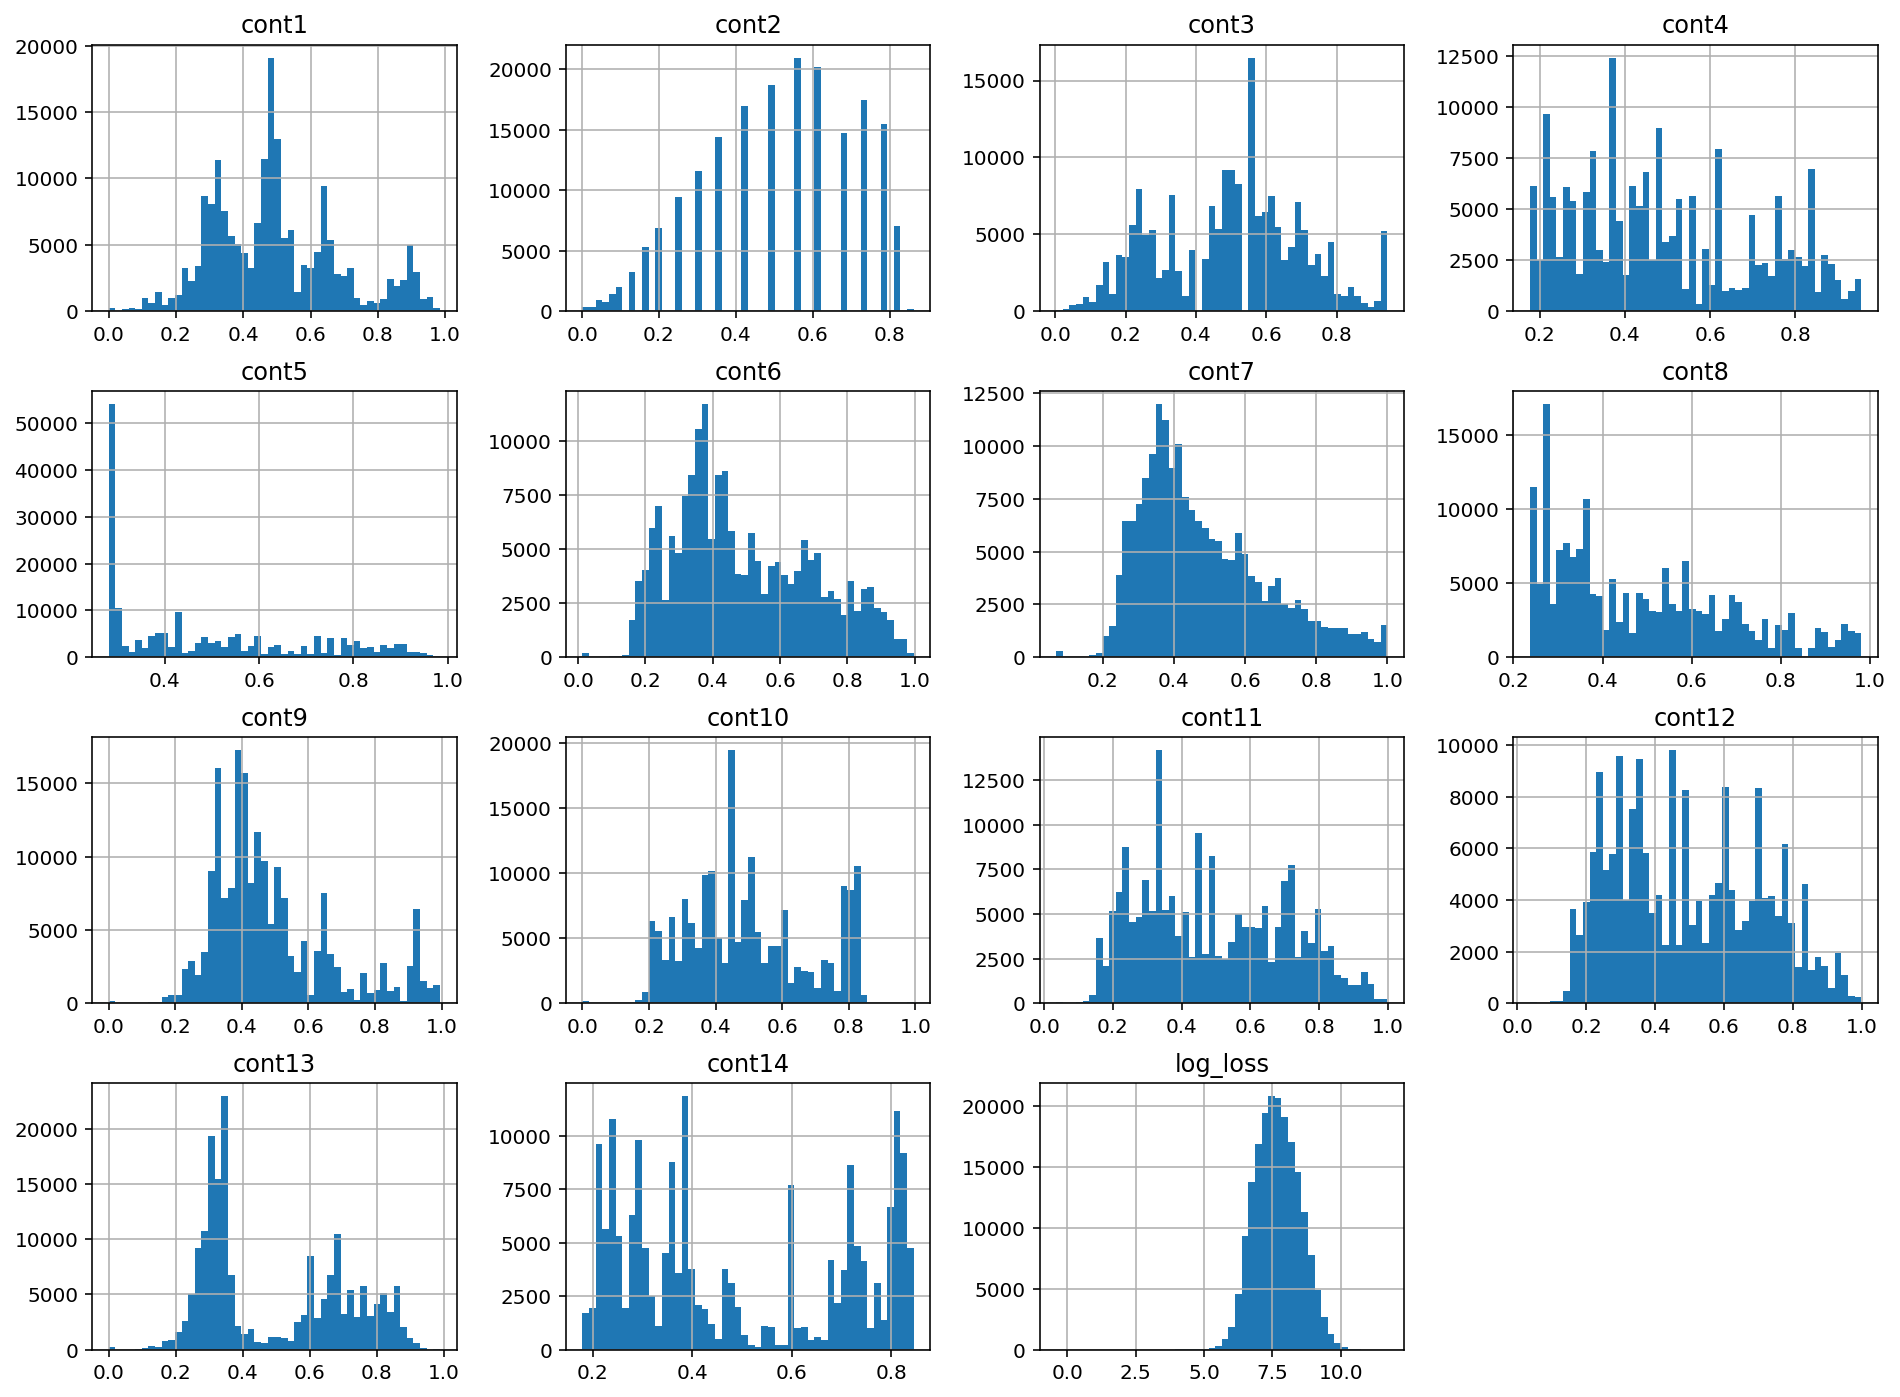

In [49]:
train[cont_features].hist(bins=50,figsize=(16,12))

<AxesSubplot:>

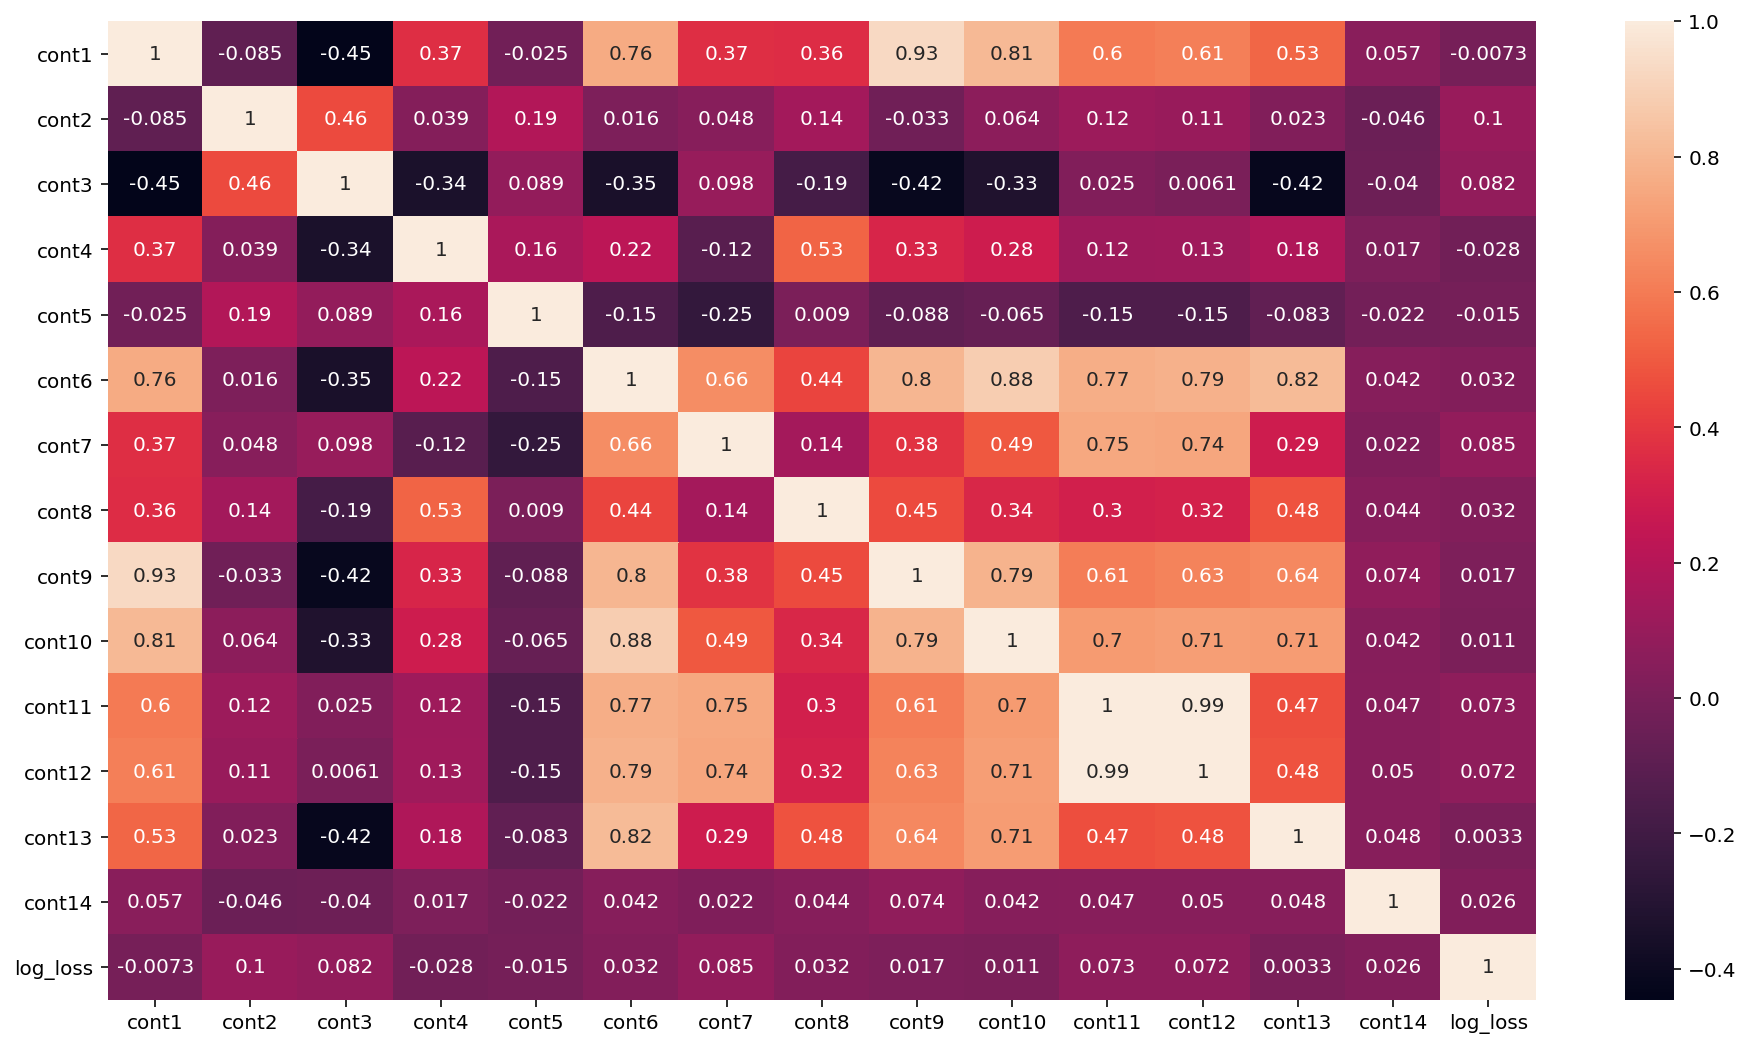

In [50]:
plt.subplots(figsize=(16,9))
correlation_mat = train[cont_features].corr()
sns.heatmap(correlation_mat,annot=True)

In [53]:
import xgboost as xgb
import pandas as pd
import numpy as np
import pickle
import sys
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error,make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from scipy.sparse import csr_matrix,hstack
from sklearn.model_selection import KFold,train_test_split
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [55]:
features = [x for x in train.columns if x not in ['id','loss','log_loss']]
cat_features = [x for x in train.select_dtypes(include=['object']).columns if x not in ['id','loss','log_loss']]
num_features = [x for x in train.select_dtypes(exclude=['object']).columns if x not in ['id','loss','log_loss']]

In [57]:
print('Categorical features:',len(cat_features))
print('Numberical features',len(num_features))


Categorical features: 116
Numberical features 14


In [59]:
ntrain = train.shape[0]
train_x = train[features]
train_y = train['log_loss']


In [61]:
for c in range(len(cat_features)):
    train_x[cat_features[c]]=train_x[cat_features[c]].astype('category').cat.codes
print('Xtrain:',train_x.shape)
print('ytrain:',train_y.shape)

Xtrain: (188318, 130)
ytrain: (188318,)


In [63]:
def xg_eval_mae(yhat,dtrain):
    y = dtrain.get_label()
    return 'mae',mean_absolute_error(np.exp(y),np.exp(yhat))
dtrain = xgb.DMatrix(train_x,train['log_loss']) 

In [65]:
xgb_params = {
    'seed':0,
    'eta':0.1,
    'colsample_bytree':0.5,
    'silent':1,
    'subsample':0.5,
    'objective':'reg:linear',
    'max_depth':5,
    'min_child_weight':3
}

In [67]:
bst_cv1 = xgb.cv(xgb_params,dtrain,num_boost_round=50,nfold=3,seed=0,feval=xg_eval_mae,maximize=False,early_stopping_rounds=10)
print('CV score:',bst_cv1.iloc[-1,:]['test-mae-mean'])

CV score: 1220.054769


<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

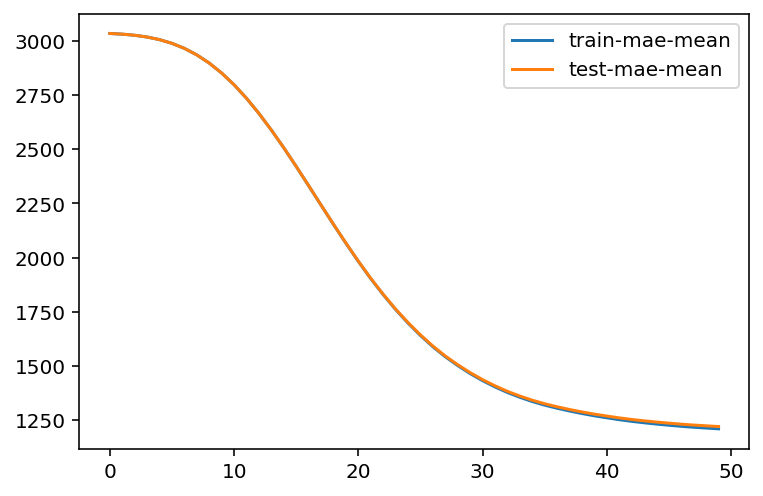

In [70]:
plt.figure()
bst_cv1[['train-mae-mean', 'test-mae-mean']].plot()



In [72]:
bst_cv2 = xgb.cv(xgb_params,dtrain,num_boost_round=100,nfold=3,seed=0,feval=xg_eval_mae,maximize=False,early_stopping_rounds=10)
print('CV score:',bst_cv2.iloc[-1,:]['test-mae-mean'])

CV score: 1171.2875163333333


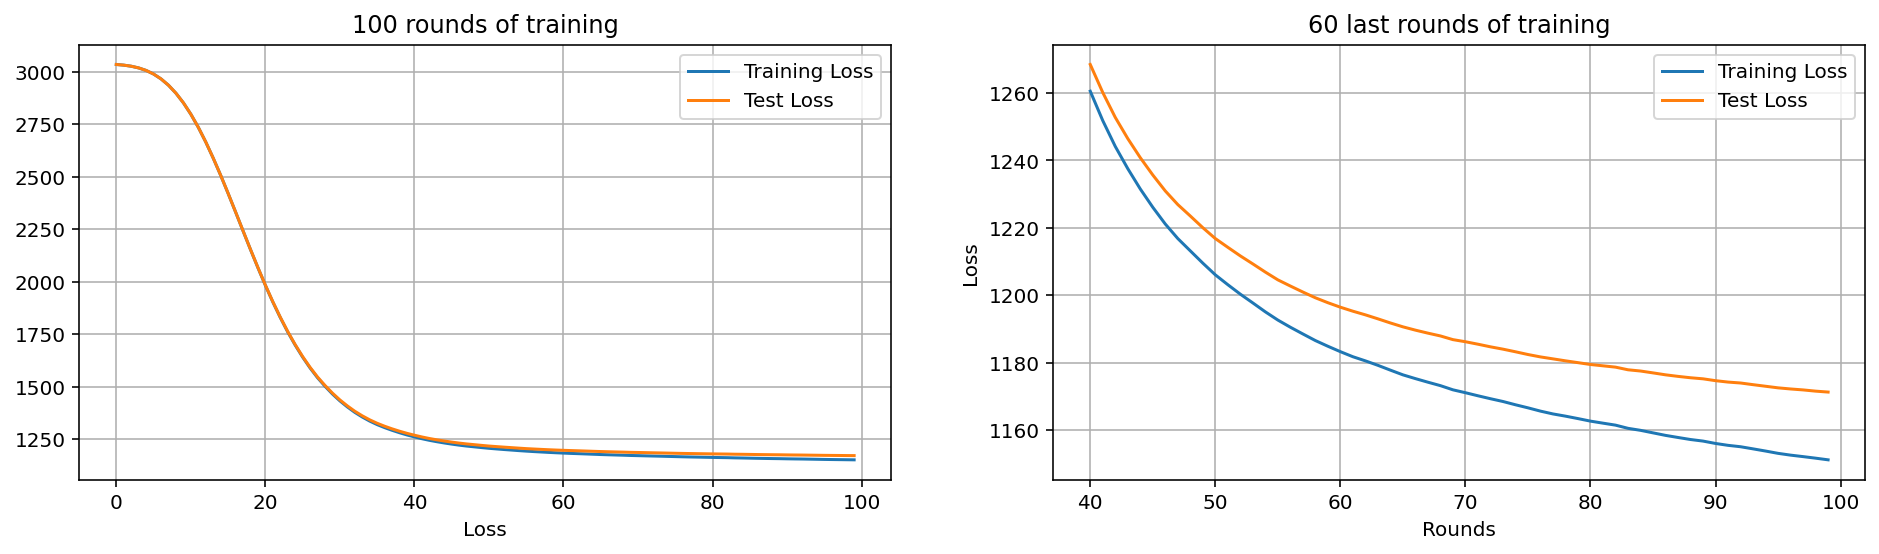

In [75]:
fig,(ax1,ax2)= plt.subplots(1,2)
fig.set_size_inches(16,4)
ax1.set_title('100 rounds of training')
ax1.set_xlabel('Round')
ax1.set_xlabel('Loss')
ax1.grid(True)
ax1.plot(bst_cv2[['train-mae-mean','test-mae-mean']])
ax1.legend(['Training Loss','Test Loss'])

ax2.set_title('60 last rounds of training')
ax2.set_xlabel('Rounds')
ax2.set_ylabel('Loss')
ax2.grid(True)
ax2.plot(bst_cv2.iloc[40:][['train-mae-mean', 'test-mae-mean']])
ax2.legend(['Training Loss', 'Test Loss'])

In [77]:
class XGBoostRegressor(object):
    def __init__(self,**kwargs):
        self.params = kwargs
        if 'num_boost_round' in self.params:
            self.num_boost_round = self.params['num_boost_round']
        self.params.update({'silent':1,'objective':'reg:linear','seed':0})
    
    def fit(self,x_train,y_train):
        dtrain =xgb.DMatrix(x_train,y_train)
        self.bst=xgb.train(params=self.params,dtrain=dtrain,num_boost_round=self.num_boost_round,
                          feval=xg_eval_mae,maximize=False)
    def predict(self,x_pred):
        dpred = xgb.DMatrix(x_pred)
        return self.bst.predict(dpred)
    
    def kfold(self,x_train,y_train,nfold=5):
        dtrain = xgb.DMatrix(x_train,y_train)
        cv_rounds = xgb.cv(params=self.params,dtrain=dtrain,num_boost_round=self.num_boost_round,nfold = nfold,feval= xg_eval_mae,maximize=False,early_stopping_rounds=10)
        return cv_rounds.ilos[-1,:]
    def plot_feature_importance(self):
        feat_imp = pd.Series(self.bst.get_fscore()).sort_values(ascending=False)
        feat_imp.plot(title='Feature Importances')
        plt.ylabel('Feature Importance Score')
    def get_params(self,deep=True):
        return self.params
    def set_params(self,**params):
        self.params.update(params)
        return self

In [79]:
def mae_score(y_true,y_pred):
    return mean_absolute_error(np.exp(y_true),np.exp(y_pred))
mae_scorer = make_scorer(mae_score,greater_is_better=False)